#**HOMEWORK: BLUE BIKE TRIP DURATION PREDICTION (Total: / 15 points)**

Context: You have received some data from Blue Bikes (the Boston Bikesharing Service). They have asked you to provide a predictive model that can accurately predict how long a given bike rental will last, at the time the rental begins. The use case is that the bike share company wants to be able to predict how long a customer will have the bike in their possession, when they begin their retnal, in order to better manage operational efficiency across the bike network. Note that when the customer initiates a bike rental, they enter the starting station ID and ending station ID for their trip, into the mobile app.

# *Name: Yu Ting Hung*
# *Email: ythung@bu.edu*

#*Import and Pre-process Data*

In [1]:
!pip install haversine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np

def get_cyclic_minute(start_time, end_time):

    st_min, st_second = start_time.split(":")[1].split(".")
    ed_min, ed_second = end_time.split(":")[1].split(".")

    st_min = float(st_min)
    st_second = float(st_second)
    ed_min = float(ed_min)
    ed_second = float(ed_second)
    # Convert minutes to radians
    st_angle = 2 * np.pi * (st_min / 60 + st_second / 3600)
    ed_angle = 2 * np.pi * (ed_min / 60 + ed_second / 3600)

    # Encode as sine and cosine waves
    st_minute_sin = np.sin(st_angle)
    st_minute_cos = np.cos(st_angle)

    ed_minute_sin = np.sin(ed_angle)
    ed_minute_cos = np.cos(ed_angle)

    #print(f"Start time: {start_time}")
    #print(f"Minute: {st_min}")
    #print(f"Second: {st_second}")
    #print(f"Angle: {st_angle}")
    #print(f"Sine of angle: {st_minute_sin}")
    #print(f"Cosine of angle: {st_minute_cos}")

    return st_minute_sin, st_minute_cos, ed_minute_sin, ed_minute_cos

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from haversine import haversine, Unit
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

bluebikes = pd.read_csv('https://raw.githubusercontent.com/gburtch/BA865-2023/main/Lecture%20Materials/C_Assignment/bluebikes_sample.csv')
# station_info = pd.read_csv('https://raw.githubusercontent.com/yuting-hung/Bluebikes-trip-duration-prediction/main/current_bluebikes_stations.csv')
station_info = pd.read_csv('https://raw.githubusercontent.com/yuting-hung/Bluebikes-trip-duration-prediction/main/merged_bluebikes_stations.csv')

# adding the distance between start and end station
def calc_distance(row):
    start_coords = (row['start_station_latitude'], row['start_station_longitude'])
    end_coords = (row['end_station_latitude'], row['end_station_longitude'])
    return haversine(start_coords, end_coords, unit=Unit.METERS)

# This function MUST return a pair of objects (predictors, labels, in that order) as numpy arrays.
def processData(data):
    data.columns = data.columns.str.replace(' ', '_')
    #print(len(data))
    data = data.merge(station_info[['Name', 'Total docks']], left_on='start_station_name', right_on='Name', how='left')
    data['Total docks'].fillna(15, inplace=True)
    #print(len(data))

    # apply the function to each row in the dataframe and create a new column with the distance
    data['distance'] = data.apply(calc_distance, axis=1)


    # call distance api and save the distance and duration
    #for index, row in data.iterrows():
    #    start_lat = row['start_station_latitude']
    #    start_lon = row['start_station_longitude']
    #    end_lat = row['end_station_latitude']
    #    end_lon = row['end_station_longitude']
    #    distance, duration = get_distance(start_lat, start_lon, end_lat, end_lon)
    #    data.at[index, 'distance_api'] = distance
    #    data.at[index, 'duration_api'] = duration

    for index, row in data.iterrows():
        start_min = row['starttime']
        end_min = row['stoptime']
        st_minute_sin, st_minute_cos, ed_minute_sin, ed_minute_cos = get_cyclic_minute(start_min, end_min)
        data.at[index, 'st_minute_sin'] = st_minute_sin
        data.at[index, 'st_minute_cos'] = st_minute_cos
        data.at[index, 'ed_minute_sin'] = ed_minute_sin
        data.at[index, 'ed_minute_cos'] = ed_minute_cos

    encoder = OneHotEncoder()
    encoded_vars = encoder.fit_transform(data[['usertype', 'gender', 'bikeid','start_station_id','end_station_id']]).toarray()
    encoded_var_names = encoder.get_feature_names_out(['usertype', 'gender', 'bikeid', 'start_station_id', 'end_station_id'])
    data = pd.concat([data.reset_index(drop=True), pd.DataFrame(encoded_vars, columns=encoded_var_names)], axis=1)
    ## pre-process your data here, and return your two numpy arrays...
    predictors = data[['birth_year','distance','Total docks','st_minute_sin','st_minute_cos','ed_minute_sin','ed_minute_cos']+list(encoder.get_feature_names_out(['usertype', 'gender', 'bikeid','start_station_id','end_station_id']))]
    
    labels = data['tripduration'].values
    
    train_predictors = predictors.to_numpy()
    train_labels = labels

    return train_predictors, train_labels


#*Specify Your Neural Network Architecture, Process Your Sample*

Calling the data pre-processing function on the sample.

In [4]:
predictors, labels = processData(bluebikes)

Specifying my Neural Network's structure. Note that the important thing for performance with this model actually comes down to its depth! It turns out that width isn't that important here. 


In [5]:
def build_model():
    
    # specify your model architecture here using the Keras sequential API
    model = keras.Sequential([
        #layers.Dropout(rate=0.5),
        #layers.BatchNormalization(), # This whitens the inputs to the next layer (de-mean, divide by SD, which can help with training)
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.5),
        layers.BatchNormalization(),
        layers.Dense(32, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(8, activation="relu"),
        layers.Dense(1)
    ])

    # compile your model, specifying the loss and other metrics you might want to track, plus the optimizer
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

    return model

#*Train Your Neural Network Here*

In [6]:
#from google.colab import drive

#drive.mount('/content/drive')

#callbacks = [
#    keras.callbacks.ModelCheckpoint(
#        filepath="drive/My Drive/BA865/Individual Assignment/Bluebikes Models",
#        save_best_only=True,
#        monitor="val_mae")
#]

#### 3-fold data:

In [ ]:
import numpy as np

k = 3 
num_val_samples = len(predictors) // k # floor division (i.e., round down to nearest integer.)
num_epochs = 50
all_mae_histories = []  

print("In total, we have",len(predictors),"training observations.")
print("With a k of",k,"we have",num_val_samples,"observations per fold.\n")

for i in range(k): # the folds are going to be indexed 0 through 3 if k = 4
    print("Processing fold #:",i)
    # if I slice past the end of the array, it just gives me what it can find! No errors.
    # This is important here, because the last fold won't produce an error, despite our slice going well beyond the end of the array.
    print("Validation data includes observations",i*num_val_samples,"through",(i+1)*num_val_samples-1) # minus 1 because a slice is up to and not including the second index.
    val_data = predictors[i * num_val_samples: (i + 1) * num_val_samples] 
    val_targets = labels[i * num_val_samples: (i + 1) * num_val_samples]
    print("Training data includes observations 0 through",i*num_val_samples-1,"joined with observations",(i+1)*num_val_samples,"through the final observation.\n")
    partial_train_data = np.concatenate(
        [predictors[:i * num_val_samples],
         predictors[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [labels[:i * num_val_samples],
         labels[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=64, verbose=1)
                        #,callbacks=callbacks)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

In total, we have 9000 training observations.
With a k of 3 we have 3000 observations per fold.

Processing fold #: 0
Validation data includes observations 0 through 2999
Training data includes observations 0 through -1 joined with observations 3000 through the final observation.

Epoch 1/50
94/94 [==============================] - 8s 9ms/step - loss: 3045964.0000 - mae: 844.0989 - val_loss: 1873619.5000 - val_mae: 826.1962
Epoch 2/50
94/94 [==============================] - 1s 6ms/step - loss: 2742414.7500 - mae: 677.0142 - val_loss: 1209346.0000 - val_mae: 406.4196
Epoch 3/50
94/94 [==============================] - 1s 6ms/step - loss: 2171333.7500 - mae: 365.1285 - val_loss: 1074602.6250 - val_mae: 335.1278
Epoch 4/50
94/94 [==============================] - 1s 6ms/step - loss: 2167275.5000 - mae: 362.0218 - val_loss: 1066387.3750 - val_mae: 339.0562
Epoch 5/50
94/94 [==============================] - 1s 6ms/step - loss: 2178628.0000 - mae: 368.3142 - val_loss: 1084547.7500 - val_ma

#### one training and test data

In [106]:
#model = build_model()

#x_val = predictors[:2000]
#partial_x_train = predictors[2000:]
#y_val = labels[:2000]
#partial_y_train = labels[2000:]

#history = model.fit(partial_x_train,
#                    partial_y_train,
#                    epochs=150,
#                    batch_size=512,
#                    validation_data=(x_val, y_val))

Epoch 1/150
13/13 [==============================] - 2s 65ms/step - loss: 2968731.0000 - mae: 869.6441 - val_loss: 1160430.0000 - val_mae: 749.1823
Epoch 2/150
13/13 [==============================] - 1s 52ms/step - loss: 2965387.0000 - mae: 868.3439 - val_loss: 1159887.6250 - val_mae: 748.7977
Epoch 3/150
13/13 [==============================] - 1s 44ms/step - loss: 2961593.5000 - mae: 866.8679 - val_loss: 1158280.5000 - val_mae: 748.0867
Epoch 4/150
13/13 [==============================] - 1s 39ms/step - loss: 2956964.2500 - mae: 865.0754 - val_loss: 1156180.6250 - val_mae: 746.8033
Epoch 5/150
13/13 [==============================] - 1s 48ms/step - loss: 2951754.7500 - mae: 862.8466 - val_loss: 1151645.7500 - val_mae: 744.7249
Epoch 6/150
13/13 [==============================] - 0s 30ms/step - loss: 2944228.7500 - mae: 859.8277 - val_loss: 1145756.2500 - val_mae: 741.8694
Epoch 7/150
13/13 [==============================] - 0s 27ms/step - loss: 2934841.2500 - mae: 856.0674 - val_los

Plot your model performance over training here:

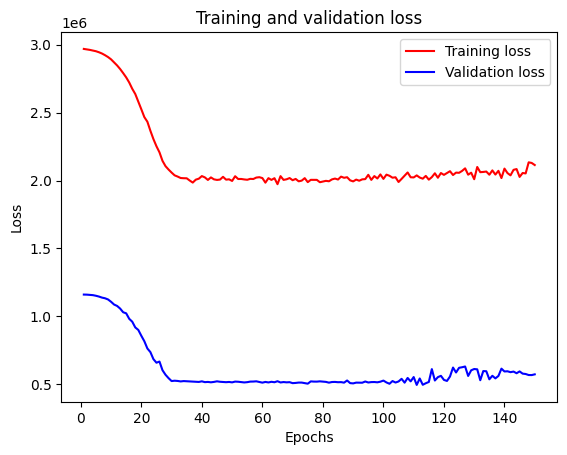

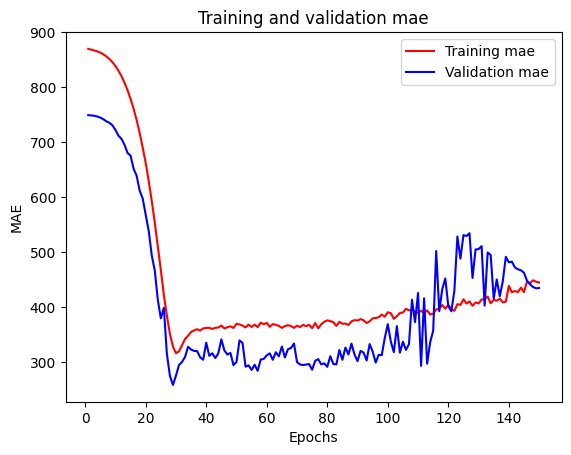

In [107]:
import matplotlib.pyplot as plt

# Build your plot.

# printing loss
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "r", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# printing accuracy
acc = history_dict["mae"]
val_acc = history_dict["val_mae"]
plt.plot(epochs, acc, "r", label="Training mae")
plt.plot(epochs, val_acc, "b", label="Validation mae")
plt.title("Training and validation mae")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

#*Choose Final Configuration and Produce That Model Here:*

282/282 [==============================] - 1s 3ms/step - loss: 1780220.8750 - mae: 324.4838


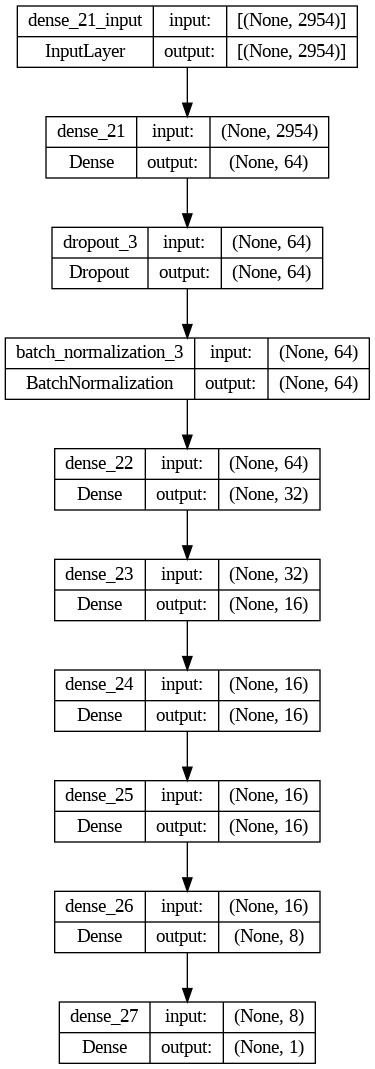

In [16]:
#model = keras.models.load_model("drive/My Drive/BA865/Individual Assignment/Bluebikes Models")

import numpy as np

k = 3 
num_val_samples = len(predictors) // k # floor division (i.e., round down to nearest integer.)
num_epochs = 50
all_mae_histories = []  

print("In total, we have",len(predictors),"training observations.")
print("With a k of",k,"we have",num_val_samples,"observations per fold.\n")

for i in range(k): # the folds are going to be indexed 0 through 3 if k = 4
    print("Processing fold #:",i)
    # if I slice past the end of the array, it just gives me what it can find! No errors.
    # This is important here, because the last fold won't produce an error, despite our slice going well beyond the end of the array.
    print("Validation data includes observations",i*num_val_samples,"through",(i+1)*num_val_samples-1) # minus 1 because a slice is up to and not including the second index.
    val_data = predictors[i * num_val_samples: (i + 1) * num_val_samples] 
    val_targets = labels[i * num_val_samples: (i + 1) * num_val_samples]
    print("Training data includes observations 0 through",i*num_val_samples-1,"joined with observations",(i+1)*num_val_samples,"through the final observation.\n")
    partial_train_data = np.concatenate(
        [predictors[:i * num_val_samples],
         predictors[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [labels[:i * num_val_samples],
         labels[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=64, verbose=1)
                        #,callbacks=callbacks)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)


loss_metrics = model.evaluate(predictors,labels,verbose=1)
# keras.utils.plot_model(model, "my_model.png", show_shapes=True)

Here's what the resulting model looks like.

In [17]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 64)                189120    
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 batch_normalization_3 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_22 (Dense)            (None, 32)                2080      
                                                                 
 dense_23 (Dense)            (None, 16)                528       
                                                                 
 dense_24 (Dense)            (None, 16)                272       
                                                      

282/282 [==============================] - 1s 3ms/step - loss: 1780220.8750 - mae: 324.4838


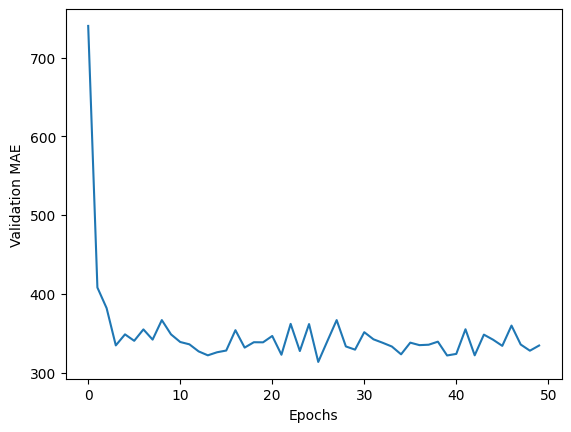

In [18]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

plt.plot(average_mae_history[:])
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

#*Final Evaluation*

Don't modify this section; this is the code I will use to evaluate that your model is output properly and that it can generate predictions on new test observations it has never seen before. If your model breaks when I feed it the new data, I will deduct marks, so please ensure that your data pre-processing function works properly!

In [ ]:
from google.colab import files
import io

# I'm going to upload my holdout dataset (same set of features)
uploaded = files.upload()
bluebike_holdout = pd.read_csv(io.BytesIO(uploaded['bluebikes_holdout.csv']))

# I'm then going to pre-process it using your commands.
holdout_predictors, holdout_labels = processData(bluebike_holdout)

# Then I'm going to evaluate your model's performance on that data.
loss_metrics = model.evaluate(holdout_predictors,holdout_labels,verbose=1)